# study c/a and ycen calibration landscape 

In [22]:
%matplotlib notebook
import LaueTools
import os
import numpy as np
import matplotlib.pyplot as plt
import LaueTools.generaltools as GT
import LaueTools.CrystalParameters as CP
import LaueTools.dict_LaueTools as dictLT
import copy
import LaueTools.FitOrient as FitO

from tqdm import tqdm

In [7]:
folder='/home/micha/LaueProjects/SiC_rieutord/'
filename_idx = "img_0002_LT_6.fit"

key_material = '4H-SiC'

#resfit = IOLT.readfile_fit(os.path.join(folder,filename_idx), verbose=True,fileextensionmarker='.dat')
with open(os.path.join(folder,filename_idx),'r') as f:
    datarefSiC = np.loadtxt(f, skiprows=7)
ubmat = np.array([[0.5671652,-0.5034516,-0.6518130],
                  [0.6983034,0.7135714,0.0564652],
                  [0.4366876,-0.4871883,0.7562747]])
detparam0 = [79.17600, 972.2400, 937.999, 0.4110000, 0.4300000]
CCDlabel='sCMOS'
pixelsize = 0.0734
framedim = (2018, 2016)

ispot=datarefSiC[:,0]
hkl=datarefSiC[:,2:5]
xy=datarefSiC[:,7:9]
XYdevCalib = datarefSiC[:,9:11]
xpts,ypts = xy.T


print('nb of spots', len(xpts))

nb of spots 146


<IPython.core.display.Javascript object>


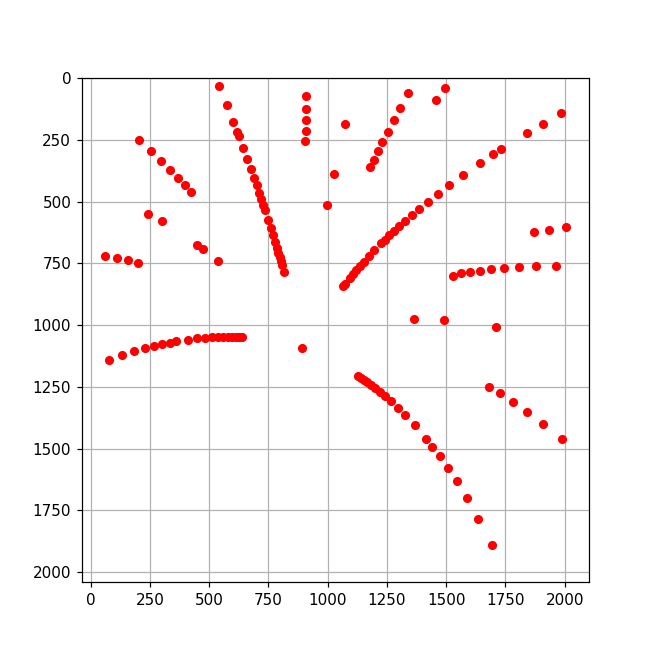

In [8]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(xpts, ypts, 'r.',markersize=10)
ax.set_ylim(2040,0)
ax.grid()

In [106]:
# calibration refinement
# deltaycen = 2
# deltac = -0.02
ycenfixed = True

#----------------------------------------
starting_orientmatrix = np.dot(ubmat,GT.matRot([-1,2,0],-0.000002))
calibration_parameter = copy.copy(detparam0)

# calibration_parameter[2]=detparam0[2]+deltaycen

latticeparams0 = dictLT.dict_Materials[key_material][1]
latticeparams = copy.copy(latticeparams0)
print('latticeparams',latticeparams)


# latticeparams[2]=latticeparams0[2]+deltac
# B0 = CP.calc_B_RR(latticeparams)
pixX, pixY = xpts, ypts
miller = hkl
#print('miller', miller)

nspots = np.arange(len(pixX))

print("starting_orientmatrix", starting_orientmatrix)
print('nb of spots',len(pixX))

# allparameters = np.array(calibration_parameter + [0.0, 0.0, 0.0])
DATA_Q = miller  # all miller indices must be entered in fit procedures

# find the best orientation with a pure rotation matrix (1) or product pure rotation* strain matrix (triangle up)  (0)
pureRotation = 1

RESULTS = []
for deltac in np.linspace(-0.002*latticeparams0[2], 0.002*latticeparams0[2],3):
    latticeparams[2]=latticeparams0[2]+deltac
    print('latticeparams[2]',latticeparams[2])
    B0 = CP.calc_B_RR(latticeparams)
    for deltaycen in np.linspace(-1,1,3):
        calibration_parameter[2]=detparam0[2]+deltaycen
        allparameters = np.array(calibration_parameter + [0.0, 0.0, 0.0])
        if 1:
            print(" 1 c'est parti",)
            # all parameters
            if not ycenfixed:
                print('ycen is free like others')
                initial_values = calibration_parameter + [-0.0,0,0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                arr_indexvaryingparameters = np.array([0, 1, 2, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            # all except ycen
            else:
                print('ycen is FIXED')
                initial_values = calibration_parameter[:2]+ calibration_parameter[3:]+ [0,0,0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                print('calibration_parameter',calibration_parameter)
                arr_indexvaryingparameters = np.array([0, 1, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            results = FitO.fit_on_demand_calibration(initial_values,
                                                        miller,
                                                        allparameters,
                                                        FitO.error_function_on_demand_calibration,
                                                        arr_indexvaryingparameters,
                                                        nspots,
                                                        pixX,
                                                        pixY,
                                                        initrot=starting_orientmatrix,
                                                        vecteurref=B0,
                                                     pureRotation=0,
                                                        pixelsize=pixelsize,
                                                        dim=framedim,
                                                        verbose=0,
                                                        returnallinfos=1)

        if 0: # redo
            print("\n\n#### \n  2 c'est parti encore une fois")
            # all parameters
            if not ycenfixed:
                print('ycen is free like others')
                initial_values = results[0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                arr_indexvaryingparameters = np.array([0, 1, 2, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            # all except ycen
            else:
                print('ycen is FIXED')
                
                print('calibration_parameter',calibration_parameter)
                initial_values = results[0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                arr_indexvaryingparameters = np.array([0, 1, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            results2 = FitO.fit_on_demand_calibration(initial_values,
                                                        miller,
                                                        allparameters,
                                                        FitO.error_function_on_demand_calibration,
                                                        arr_indexvaryingparameters,
                                                        nspots,
                                                        pixX,
                                                        pixY,
                                                        initrot=starting_orientmatrix,
                                                        vecteurref=B0,
                                                     pureRotation=0,
                                                        pixelsize=pixelsize,
                                                        dim=framedim,
                                                        verbose=0,
                                                        returnallinfos=1)

        if 0: # redo
            print("\n\n#### \n 3 c'est parti encore encore une fois")
            # all parameters
            if not ycenfixed:
                print('ycen is free like others')
                initial_values = results2[0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                arr_indexvaryingparameters = np.array([0, 1, 2, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            # all except ycen
            else:
                print('ycen is FIXED')
                initial_values = results2[0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                arr_indexvaryingparameters = np.array([0, 1, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            results3 = FitO.fit_on_demand_calibration(initial_values,
                                                        miller,
                                                        allparameters,
                                                        FitO.error_function_on_demand_calibration,
                                                        arr_indexvaryingparameters,
                                                        nspots,
                                                        pixX,
                                                        pixY,
                                                        initrot=starting_orientmatrix,
                                                        vecteurref=B0,
                                                     pureRotation=0,
                                                        pixelsize=pixelsize,
                                                        dim=framedim,
                                                        verbose=0,
                                                        returnallinfos=1)
            meanpixdev = np.mean(results3[1][0])
            RESULTS.append([deltac, deltaycen, meanpixdev]+results3[0].tolist())
        

latticeparams [3.073, 3.073, 10.013000000000002, 90, 90, 120]
starting_orientmatrix [[ 0.567165179649486 -0.503451610175257 -0.651813009848459]
 [ 0.698303401762922  0.713571400881461  0.056465167058642]
 [ 0.436687623611954 -0.487188288194023  0.756274693971352]]
nb of spots 164
latticeparams[2] 9.992974000000002
 1 c'est parti
ycen is FIXED
calibration_parameter [79.176, 972.24, 936.999, 0.411, 0.43]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.981274121331870e+01  9.725517769933558e+02  4.706924957100413e-01
  4.304962072692021e-01 -1.760209675061381e-02  7.673112999865650e-03
  3.934908118123861e-02]
mean residues 0.9742791079711985

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [79.176, 972.24, 937.999, 0.411, 0.43]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.980266973466601e+01  9.725539914167132e+02  4.971561406496766e-01
  4.298837739157230e-01 -1.404723005290391e-02  3.696350829335621e-0

In [23]:
# calibration refinement  by varyng one parameter and changing initial condition

ycenfixed = True
detparam0=  [79.176, 972.24, 937.99, 0.411, 0.430]
#----------------------------------------
calibration_parameter = copy.copy(detparam0)

print('detparam0',detparam0)
latticeparams0 = dictLT.dict_Materials[key_material][1]
latticeparams = copy.copy(latticeparams0)
print('latticeparams',latticeparams)


# latticeparams[2]=latticeparams0[2]+deltac
# B0 = CP.calc_B_RR(latticeparams)
pixX, pixY = xpts, ypts
miller = hkl
#print('miller', miller)

nspots = np.arange(len(pixX))

print('nb of spots',len(pixX))

# allparameters = np.array(calibration_parameter + [0.0, 0.0, 0.0])
DATA_Q = miller  # all miller indices must be entered in fit procedures

RESULTS = []



# dd xcen xbet xgam ub11 ub12 ub13 ub21 ub22 ub23 ub31 ub 32 ub33
minitab = np.array([80.563, 977.26, .383, .738] )
miniub = np.array([[0.5715389049487738, -0.5035114038685251, -0.6479348819873846],
[0.6966812830171479, 0.7149550980212136, 0.05894487290561483],
[0.4335649115875403, -0.4850933622358128, 0.7594114947130294]])

maxitab = np.array([80.172, 972.83,  0.686, .430])
maxiub = np.array([[0.5670018687694469, -0.5039155667358652, -0.6515965370351091],
[0.6986589651818927, 0.7132304939508235, 0.056373868123873495],
[0.4363308305853447, -0.4872078203368235, 0.7564680215030567]])

#topleft
tabtl = np.array([78.492, 974.374, 0.024, 0.617])  #ycen = 925  c = 10.153
ubtl = np.array([[0.5675818902151641, -0.5028434614955295, -0.6519197156646027],
[0.6978631270692587, 0.7139692402902912, 0.056877763630351304],
[0.43684999291892535, -0.487233489456458, 0.7561517916214513]])

# topright
tabtr = np.array([78.096, 971.57,0.396, 0.44])  #ycen = 943  c = 10.153
ubtr = np.array([[0.5667994469655647, -0.5022690837786529, -0.6530422794738753],
[0.6978212797664575, 0.7140417364873872, 0.05647973306522183],
[0.43793139983450585, -0.48771945022897417, 0.755212386426885]])

# bottomleft
tabbl = np.array([80.563, 977.26, .383, .738] )   #ycen = 925  c = 9.953
ubbl = np.array([[0.5715389049487738, -0.5035114038685251, -0.6479348819873846],
[0.6966812830171479, 0.7149550980212136, 0.05894487290561483],
[0.4335649115875403, -0.4850933622358128, 0.7594114947130294]])

# bottomright
tabbr = np.array([80.172, 972.83,  0.686, .430])   #ycen = 943  c = 9.953
ubbr = np.array([[0.5670018687694469, -0.5039155667358652, -0.6515965370351091],
[0.6986589651818927, 0.7132304939508235, 0.056373868123873495],
[0.4363308305853447, -0.4872078203368235, 0.7564680215030567]])

nbptsc = 19  # nb pts to scan c values
nbptsycen = 19  # nb pts to scan ycen values
listcvalues= np.linspace(9.953,10.153,nbptsc)

for ck in tqdm(range(len(listcvalues))):
    cval = listcvalues[ck]
    latticeparams[2]=cval
    print('latticeparams[2]',latticeparams[2])
    B0 = CP.calc_B_RR(latticeparams)
    
    minitab = tabbl+(tabtl-tabbl)*ck/(nbptsycen-1)
    maxitab = tabbr+(tabtr-tabbr)*ck/(nbptsycen-1)
    miniub = ubbl+(ubtl-ubbl)*ck/(nbptsycen-1)
    maxiub = ubbr+(ubtr-ubbr)*ck/(nbptsycen-1)

    for k, deltaycen in enumerate(np.linspace(-13,5,nbptsycen)):
        calibration_parameter[2]=detparam0[2]+deltaycen

        tabinterpolated = (maxitab-minitab)*k/(nbptsycen-1)+minitab
        ubinterpolated = (maxiub-miniub)*k/(nbptsycen-1)+miniub

        starting_orientmatrix = ubinterpolated
        calibration_parameter[:2] = tabinterpolated[:2]
        calibration_parameter[-2:] = tabinterpolated[-2:]

        allparameters = np.array(calibration_parameter + [0.0, 0.0, 0.0])
        if 1:
            print(" 1 c'est parti",)
            # all parameters
            if not ycenfixed:
                print('ycen is free like others')
                initial_values = calibration_parameter + [-0.0,0,0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                arr_indexvaryingparameters = np.array([0, 1, 2, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            # all except ycen
            else:
                print('ycen is FIXED')
                initial_values = calibration_parameter[:2]+ calibration_parameter[-2:]+ [0,0,0] # [dd,xcen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                print('calibration_parameter',calibration_parameter)
                arr_indexvaryingparameters = np.array([0, 1, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            results = FitO.fit_on_demand_calibration(initial_values,
                                                        miller,
                                                        allparameters,
                                                        FitO.error_function_on_demand_calibration,
                                                        arr_indexvaryingparameters,
                                                        nspots,
                                                        pixX,
                                                        pixY,
                                                        initrot=starting_orientmatrix,
                                                        vecteurref=B0,
                                                     pureRotation=0,
                                                        pixelsize=pixelsize,
                                                        dim=framedim,
                                                        verbose=0,
                                                        returnallinfos=1)

        if 1: # redo
            print("\n\n#### \n  2 c'est parti encore une fois")
            # all parameters
            if not ycenfixed:
                print('ycen is free like others')
                initial_values = results[0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                arr_indexvaryingparameters = np.array([0, 1, 2, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            # all except ycen
            else:
                #print('ycen is FIXED')

                #print('calibration_parameter',calibration_parameter)
                initial_values = results[0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                arr_indexvaryingparameters = np.array([0, 1, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            results2 = FitO.fit_on_demand_calibration(initial_values,
                                                        miller,
                                                        allparameters,
                                                        FitO.error_function_on_demand_calibration,
                                                        arr_indexvaryingparameters,
                                                        nspots,
                                                        pixX,
                                                        pixY,
                                                        initrot=starting_orientmatrix,
                                                        vecteurref=B0,
                                                     pureRotation=0,
                                                        pixelsize=pixelsize,
                                                        dim=framedim,
                                                        verbose=0,
                                                        returnallinfos=1)

        if 1: # redo
            print("\n\n#### \n 3 c'est parti encore encore une fois")
            # all parameters
            if not ycenfixed:
                print('ycen is free like others')
                initial_values = results2[0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                arr_indexvaryingparameters = np.array([0, 1, 2, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            # all except ycen
            else:
                #print('ycen is FIXED')
                initial_values = results2[0] # [dd,xcen,ycen,ang1,ang2]+[deltaang1, deltaang2, deltaang3 ]
                arr_indexvaryingparameters = np.array([0, 1, 3, 4, 5, 6, 7])  # indices of position of parameters in [dd,xcen,ycen,ang1,ang2]
            results3 = FitO.fit_on_demand_calibration(initial_values,
                                                        miller,
                                                        allparameters,
                                                        FitO.error_function_on_demand_calibration,
                                                        arr_indexvaryingparameters,
                                                        nspots,
                                                        pixX,
                                                        pixY,
                                                        initrot=starting_orientmatrix,
                                                        vecteurref=B0,
                                                     pureRotation=0,
                                                        pixelsize=pixelsize,
                                                        dim=framedim,
                                                        verbose=0,
                                                        returnallinfos=1)
            meanpixdev = np.mean(results3[1][0])
            RESULTS.append([cval, deltaycen, meanpixdev]+results3[0].tolist())


  0%|          | 0/19 [00:00<?, ?it/s]

detparam0 [79.176, 972.24, 937.99, 0.411, 0.43]
latticeparams [3.073, 3.073, 10.053, 90, 90, 120]
nb of spots 146
latticeparams[2] 9.953
 1 c'est parti
ycen is FIXED
calibration_parameter [80.563, 977.26, 924.99, 0.383, 0.738]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.061792382442025e+01  9.763855073252303e+02  3.185181516887526e-01
  8.596421167620504e-01  5.257074075428322e-02  6.422489215743597e-02
 -5.164581374557719e-02]
mean residues 2.8047472747014477

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.060089957811400e+01  9.752679130354811e+02  3.019004808571347e-01
  9.021275336999328e-01  8.996991080464267e-02  1.100522570414986e-01
 -7.125201828513969e-02]
mean residues 2.80364543951635

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.060283807046503e+


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.039726322504836e+01  9.738156548836179e+02  4.237935287536657e-01
  6.995798166420850e-01  7.616061188939879e-02  5.335711664570444e-02
 -4.483411421245211e-02]
mean residues 1.8194756371690626

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [80.38922222222222, 975.2911111111111, 932.99, 0.5176666666666667, 0.6011111111111112]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.037420799729210e+01  9.741280251458007e+02  4.416174982674442e-01
  6.781277590328951e-01  5.961153807434780e-02  3.764917135681307e-02
 -4.461356575907338e-02]
mean residues 1.6913089140354336

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.036781378179512e+01  9.736252877117765e+02  4.407469060115317e-01
  6.716049883531290e-01  7.395990114790012e-02  4.535888829665862e-02
 -4.1632869364


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.016378770966240e+01  9.727068144300638e+02  5.573050672478022e-01
  4.902147366930609e-01  4.836561613924069e-02 -1.204818331176022e-02
 -2.621951130317087e-02]
mean residues 1.0703326239439128

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.015501856138057e+01  9.720100904692888e+02  5.568831339706807e-01
  4.777817199198182e-01  6.811576178515945e-02 -3.105475718828381e-03
 -2.052261442618181e-02]
mean residues 1.0663153176773956

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.015579155562571e+01  9.720596067035872e+02  5.577833605894725e-01
  4.750242962501097e-01  6.641039537621936e-02 -5.564917314785499e-03
 -1.928546684364902e-02]
mean residues 1.065547635886085

-------------------------------------

 1 c'est 

  5%|▌         | 1/19 [01:55<34:36, 115.36s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.006307894712391e+01  9.713989048141840e+02  6.067597429317096e-01
  3.918321288606730e-01  6.364422081365632e-02 -2.710518680512959e-02
 -1.063414188377943e-02]
mean residues 0.9719098775332035

-------------------------------------

latticeparams[2] 9.96411111111111
 1 c'est parti
ycen is FIXED
calibration_parameter [80.44794444444445, 977.0996666666666, 924.99, 0.3630555555555556, 0.7312777777777778]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.050066226095123e+01  9.763756884228297e+02  3.065918108066387e-01
  8.394308476318576e-01  3.869146719422956e-02  6.272543113409565e-02
 -4.386975459149946e-02]
mean residues 2.7207328217474167

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.048380172741302e+01  9.752990500362521e+02  2.884585689750375e-01
  8.888704911124683e-01  7.549234017360913e-02  1.


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.029242563145216e+01  9.747365104026919e+02  4.170802449889838e-01
  6.777681819766298e-01  3.843393635801663e-02  2.696331588546612e-02
 -3.591828319926613e-02]
mean residues 1.7393133203058784

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.027867100873725e+01  9.737915734214207e+02  4.074407914981030e-01
  6.948136154056624e-01  6.835126932153889e-02  5.585977015663934e-02
 -4.396426050103525e-02]
mean residues 1.7315679592094413

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.027914894747423e+01  9.737892134344974e+02  4.093891508400282e-01
  6.881669002663402e-01  6.774453317126372e-02  5.265714825204644e-02
 -4.083655126828722e-02]
mean residues 1.7305507558894928

-------------------------------------

 1 c'est


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.003828953855869e+01  9.721254165939307e+02  5.423847360284383e-01
  4.671054116816855e-01  6.043616403671347e-02 -1.142113671298865e-02
 -1.684284736818951e-02]
mean residues 0.9733649802815744

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.003687659856591e+01  9.720203297736007e+02  5.419602007066801e-01
  4.669124120869698e-01  6.349044330838051e-02 -9.294961630162579e-03
 -1.672373175102443e-02]
mean residues 0.9738139411383512

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.003696897751834e+01  9.720258914672122e+02  5.422640897184399e-01
  4.655721174064748e-01  6.322717568810331e-02 -1.009649337711313e-02
 -1.613877599455042e-02]
mean residues 0.973583236078003

-------------------------------------

 1 c'est 

 11%|█         | 2/19 [03:38<31:40, 111.81s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.994332983675375e+01  9.713003907459862e+02  5.917535128881616e-01
  3.776846042003624e-01  6.383039364255665e-02 -3.448230963342001e-02
 -5.375100868329260e-03]
mean residues 0.895308574107839

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.994446270208041e+01  9.713454265858567e+02  5.922228782657607e-01
  3.806155600469239e-01  6.248822354260000e-02 -3.368349376828780e-02
 -6.361651327189726e-03]
mean residues 0.8955189481710201

-------------------------------------

latticeparams[2] 9.975222222222222
 1 c'est parti
ycen is FIXED
calibration_parameter [80.33288888888889, 976.9393333333334, 924.99, 0.34311111111111114, 0.7245555555555555]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.038224444411584e+01  9.762859002338398e+02  2.924157795221167e-01
  8.266086705965180e-01  2.789133273622459e


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.017482387773219e+01  9.747428105565500e+02  4.031533483772376e-01
  6.631916819352305e-01  2.891585775507327e-02  2.367430894753923e-02
 -3.072195596968144e-02]
mean residues 1.6540759890247305

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.016081111895994e+01  9.737830134820409e+02  3.924943201614920e-01
  6.850473206122427e-01  5.961614954107978e-02  5.552793946446304e-02
 -4.079778989267580e-02]
mean residues 1.6447916183798235

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.016098739930474e+01  9.737538074369954e+02  3.944717517719852e-01
  6.779935251708413e-01  5.975266162479904e-02  5.272527440791179e-02
 -3.746028777280012e-02]
mean residues 1.6435979410723363

-------------------------------------

 1 c'est


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.991928331970392e+01  9.720567134869365e+02  5.269604338903804e-01
  4.567864265221989e-01  5.816885028251070e-02 -1.568134966227647e-02
 -1.327179208718061e-02]
mean residues 0.8852538920821275

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.991857007821852e+01  9.720034087282684e+02  5.270510225949576e-01
  4.548908365663824e-01  5.961288341154183e-02 -1.551906694579351e-02
 -1.245056361299941e-02]
mean residues 0.8852722146526263

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.991862794629694e+01  9.719986578468149e+02  5.272380647396796e-01
  4.546559277809190e-01  5.969736165591693e-02 -1.547930389826703e-02
 -1.229022384295896e-02]
mean residues 0.8852551533180666

-------------------------------------

 1 c'est

 16%|█▌        | 3/19 [05:21<29:02, 108.93s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.982422662385622e+01  9.711904166386453e+02  5.775635276842815e-01
  3.632022477597819e-01  6.411715006364478e-02 -4.153316410913372e-02
  3.126379853163343e-04]
mean residues 0.8271565833906261

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.982563827569108e+01  9.712888502189534e+02  5.770801186831533e-01
  3.691922274416260e-01  6.157560335190838e-02 -4.050719213539325e-02
 -2.224152846080340e-03]
mean residues 0.8271229924004053

-------------------------------------

latticeparams[2] 9.986333333333333
 1 c'est parti
ycen is FIXED
calibration_parameter [80.21783333333333, 976.779, 924.99, 0.32316666666666666, 0.7178333333333333]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.025541747588635e+01  9.758388569258549e+02  2.573291700092391e-01
  8.874822265321982e-01  3.477398019300037e-02  1.16


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.007287568806979e+01  9.739666903316646e+02  3.619593810975689e-01
  6.978696643920230e-01  5.080030744459514e-02  6.225578321440198e-02
 -3.848187331909926e-02]
mean residues 1.6975466924533777

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [80.0654537037037, 975.1616111111111, 931.99, 0.4454722222222222, 0.6065462962962963]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.005118924934891e+01  9.743757261945024e+02  3.817279347425717e-01
  6.689536449094257e-01  3.245564804484821e-02  3.879783160963323e-02
 -3.489961427700709e-02]
mean residues 1.563454714593447

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.004287469602522e+01  9.737503897766953e+02  3.776027472020819e-01
  6.742795365547612e-01  5.152007972228954e-02  5.518551898334558e-02
 -3.719762840116


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.982982176382012e+01  9.720910987500108e+02  4.952676367374128e-01
  4.711666431557023e-01  5.840695512197486e-02 -9.882476139017370e-03
 -1.136331839801810e-02]
mean residues 0.8495064762794493

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.983110526766775e+01  9.721865892079538e+02  4.956694913419371e-01
  4.716256873808112e-01  5.560309400092554e-02 -1.170594872494239e-02
 -1.155907446161591e-02]
mean residues 0.8486822054318178

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.983110532935996e+01  9.721880714883242e+02  4.955802757520689e-01
  4.719697324785927e-01  5.558955848518501e-02 -1.157316921786822e-02
 -1.171805075718803e-02]
mean residues 0.8487256854705598

-------------------------------------

 1 c'est

 21%|██        | 4/19 [07:11<27:18, 109.24s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.970435912975870e+01  9.710436118808842e+02  5.620759917536744e-01
  3.507094920189604e-01  6.584938388642045e-02 -4.698637993970384e-02
  4.882027614554299e-03]
mean residues 0.775692649976174

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.970648047121732e+01  9.712195845549697e+02  5.615594840070272e-01
  3.561683980994448e-01  6.108598046105765e-02 -4.808827424218569e-02
  2.383417530045873e-03]
mean residues 0.77377060946808

-------------------------------------

latticeparams[2] 9.997444444444444
 1 c'est parti
ycen is FIXED
calibration_parameter [80.10277777777777, 976.6186666666666, 924.99, 0.3032222222222222, 0.7111111111111111]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.013853423721829e+01  9.758439487191077e+02  2.428272060474653e-01
  8.774520486414518e-01  2.142285307925672e-02


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.993534674600185e+01  9.744346400002612e+02  3.691590815254513e-01
  6.531335196513750e-01  2.099201502896015e-02  3.414577010298497e-02
 -2.877786711594604e-02]
mean residues 1.4814793857906818

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.992535393036445e+01  9.737516513792298e+02  3.612799031452779e-01
  6.699921687925443e-01  4.300285300688596e-02  5.737431510280947e-02
 -3.654019068283856e-02]
mean residues 1.4784682491553862

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.992572272494735e+01  9.737483072298398e+02  3.634135993664957e-01
  6.616890723059362e-01  4.233564687610523e-02  5.330072264279541e-02
 -3.274660158488469e-02]
mean residues 1.4766791937110546

-------------------------------------

 1 c'est


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.968760343458374e+01  9.723571899183597e+02  4.967450259883093e-01
  4.417305733123060e-01  4.121338655189648e-02 -3.082310207116528e-02
 -8.762872829243521e-03]
mean residues 0.7276747903695386

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.968273708846499e+01  9.719902847954439e+02  4.958166346943777e-01
  4.370418545174080e-01  5.179018121116808e-02 -2.530254323532041e-02
 -6.716078843003820e-03]
mean residues 0.7249073465073897

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.968276589148047e+01  9.719653209446676e+02  4.969991792349694e-01
  4.328415872232991e-01  5.210098195342613e-02 -2.677931962258476e-02
 -4.712629583404243e-03]
mean residues 0.7245340661934356

-------------------------------------

 1 c'est

 26%|██▋       | 5/19 [09:11<26:16, 112.58s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.958801100964868e+01  9.711553174167871e+02  5.467940358368001e-01
  3.424730046146960e-01  6.025567008809922e-02 -5.592186235504574e-02
  7.488368467334723e-03]
mean residues 0.744382658872138

-------------------------------------

latticeparams[2] 10.008555555555555
 1 c'est parti
ycen is FIXED
calibration_parameter [79.98772222222223, 976.4583333333334, 924.99, 0.2832777777777778, 0.7043888888888888]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.002123717826574e+01  9.757737547281754e+02  2.296416467036235e-01
  8.608040072812656e-01  9.709711050265515e-03  1.215774729710357e-01
 -5.940614359696553e-02]
mean residues 2.402820906926084

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 8.001548117809558e+01  9.752697315396360e+02  2.318351718122323e-01
  8.423889545554412e-01  2.301754410263683e-02  1.


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.981259531451592e+01  9.741454187228368e+02  3.443163603438362e-01
  6.740437004520885e-01  2.366559467327736e-02  5.507659510661771e-02
 -3.988523313795782e-02]
mean residues 1.4039508555906577

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.980879161419439e+01  9.737444228362837e+02  3.492476372151941e-01
  6.488610520631334e-01  3.319640247709527e-02  5.130910875902061e-02
 -2.819441208663282e-02]
mean residues 1.3960864929813817

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.980821512549203e+01  9.736812986112759e+02  3.496508019188436e-01
  6.470575020066724e-01  3.484600165923354e-02  5.186397857015241e-02
 -2.727258140706327e-02]
mean residues 1.3956740033379376

-------------------------------------

 1 c'est


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.959593656952887e+01  9.721742096290046e+02  4.652789000401285e-01
  4.504322515130506e-01  4.628815306648434e-02 -2.199180397083304e-02
 -4.370855429758943e-03]
mean residues 0.6916654050887081

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.959564385006793e+01  9.721375658640711e+02  4.653226290280562e-01
  4.510596285387405e-01  4.734406065080438e-02 -2.076026702183827e-02
 -4.516137044719658e-03]
mean residues 0.6916952079113551

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [79.66073148148148, 973.1430555555555, 939.99, 0.55175, 0.4780462962962963]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.957036126171822e+01  9.724035809552256e+02  4.793071738246958e-01
  4.410134980394651e-01  3.637805817333097e-02 -3.279697996757855e-02
 -9.679462284751875

 32%|███▏      | 6/19 [11:12<24:55, 115.03s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.947053408709132e+01  9.711674544157360e+02  5.309401876188435e-01
  3.343923468009313e-01  5.765568839652831e-02 -6.263760355863103e-02
  1.001866880730326e-02]
mean residues 0.7348461249710905

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.947126188865641e+01  9.712205384771994e+02  5.310960418165358e-01
  3.349449655630417e-01  5.611320027508957e-02 -6.350010355249679e-02
  9.774659620712747e-03]
mean residues 0.7344713146533035

-------------------------------------

latticeparams[2] 10.019666666666666
 1 c'est parti
ycen is FIXED
calibration_parameter [79.87266666666667, 976.298, 924.99, 0.26333333333333336, 0.6976666666666667]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.987868236579013e+01  9.746312243750398e+02  1.570959543050530e-01
  1.052335303499175e+00  4.981252907108230e-02  2.5


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.969595031307047e+01  9.741255398533208e+02  3.306171339769120e-01
  6.606946277208748e-01  1.480012610982137e-02  5.336870197730987e-02
 -3.493121942591920e-02]
mean residues 1.3259595668735165

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.969149748777568e+01  9.737072136621495e+02  3.342454174267242e-01
  6.384590724668170e-01  2.528325665692703e-02  5.126358246995376e-02
 -2.477035800846454e-02]
mean residues 1.3188134830294287

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.969068970958122e+01  9.736445032288124e+02  3.342156317517586e-01
  6.371282237163821e-01  2.704737563854782e-02  5.193509931441573e-02
 -2.417654678736291e-02]
mean residues 1.3185781578394602

-------------------------------------

 1 c'est


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.944027061492703e+01  9.713144165204270e+02  4.678101398714895e-01
  3.947640819560516e-01  6.152196002383107e-02 -3.280075001928721e-02
  1.031052242940001e-02]
mean residues 0.6057002731662615

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.944491580948728e+01  9.717287559881732e+02  4.660184860320645e-01
  4.081518613321655e-01  5.044544233349351e-02 -3.526225628229457e-02
  4.012495345101512e-03]
mean residues 0.597090884333715

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.944659381203317e+01  9.718490685798688e+02  4.665209509374399e-01
  4.091498015041609e-01  4.690503675128328e-02 -3.732392330292568e-02
  3.606817159683212e-03]
mean residues 0.5965580838805101

-------------------------------------

 1 c'est 

 37%|███▋      | 7/19 [13:28<24:18, 121.53s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.935164425733825e+01  9.710416885031150e+02  5.155568595107772e-01
  3.216846654986458e-01  5.878986256915326e-02 -6.867150036696174e-02
  1.466823799788985e-02]
mean residues 0.7441461566852922

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.935313756167727e+01  9.711551561343662e+02  5.159231005847309e-01
  3.222629628404093e-01  5.545233137090753e-02 -7.085773005650860e-02
  1.436976427697990e-02]
mean residues 0.7429109575563873

-------------------------------------

latticeparams[2] 10.030777777777777
 1 c'est parti
ycen is FIXED
calibration_parameter [79.75761111111112, 976.1376666666666, 924.99, 0.2433888888888889, 0.6909444444444445]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.976965441643014e+01  9.749338415296609e+02  1.584154626638671e-01
  9.870736550390207e-01  2.280961383964595


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.960404727786880e+01  9.738663638612754e+02  3.022348774907639e-01
  6.570185688371807e-01  1.538247287293231e-02  6.383261551641553e-02
 -2.517545371712572e-02]
mean residues 1.384467321448719

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [79.60479938271605, 974.6607962962963, 931.99, 0.3716574074074075, 0.5909783950617284]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.955687084148222e+01  9.729227398451053e+02  2.778286139556047e-01
  7.730527963800780e-01  5.345744506515884e-02  1.398774463342303e-01
 -8.769110306005860e-02]
mean residues 1.339968813504717

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.957497498062024e+01  9.737078359811222e+02  3.195525964246377e-01
  6.275359872730051e-01  1.620776662470954e-02  5.011141996931581e-02
 -2.111559998323


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.935476757079478e+01  9.715944134335301e+02  4.351423227765041e-01
  4.182081737839672e-01  5.294596914893782e-02 -2.534100601112519e-02
  7.988007506279066e-03]
mean residues 0.5739750270526495

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.935912403630810e+01  9.719636887163583e+02  4.349834149385661e-01
  4.240330488389809e-01  4.252366964244312e-02 -3.065430686611620e-02
  5.117760800988426e-03]
mean residues 0.5683586760774013

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.936051207445010e+01  9.720507767799696e+02  4.347955502079671e-01
  4.285126082800865e-01  4.016641079559511e-02 -3.015091054647948e-02
  3.256212641556179e-03]
mean residues 0.5681612756211427

-------------------------------------

 1 c'est

 42%|████▏     | 8/19 [15:39<22:47, 124.31s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.923786471151398e+01  9.712929956520460e+02  5.002743100235565e-01
  3.169535461103508e-01  4.925773711517795e-02 -7.883345071996758e-02
  1.571051786035507e-02]
mean residues 0.7635713724233271

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.923623917084977e+01  9.711714032882419e+02  5.002543670045682e-01
  3.138256861590666e-01  5.267426071689253e-02 -7.782249347192724e-02
  1.707712477094349e-02]
mean residues 0.7650615807658594

-------------------------------------

latticeparams[2] 10.041888888888888
 1 c'est parti
ycen is FIXED
calibration_parameter [79.64255555555556, 975.9773333333334, 924.99, 0.22344444444444445, 0.6842222222222222]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.965028485344139e+01  9.747517804572930e+02  1.386550546374971e-01
  9.931275576223532e-01  1.66397401012982


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.945647758318711e+01  9.735379777572406e+02  3.043718815388212e-01
  6.153490042216939e-01  1.210501357453724e-02  5.206763940235629e-02
 -1.686631708405557e-02]
mean residues 1.1751060850079609

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.945702412002447e+01  9.735828597567823e+02  3.043214261914252e-01
  6.162321691622343e-01  1.085463741598879e-02  5.151747229283835e-02
 -1.728813260938183e-02]
mean residues 1.175130445728236

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.945711808414796e+01  9.735905097409542e+02  3.043348447439980e-01
  6.164042040900123e-01  1.064164407260241e-02  5.144214324210369e-02
 -1.736030745644327e-02]
mean residues 1.17514876022714

-------------------------------------

 1 c'est pa


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.924244388301591e+01  9.719605948383185e+02  4.198035542640065e-01
  4.136835701780791e-01  3.779787545870675e-02 -3.571952442709287e-02
  8.612917310518388e-03]
mean residues 0.5317512839068574

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.924355399806096e+01  9.720213361226369e+02  4.196746804795869e-01
  4.176971414423968e-01  3.618291732337167e-02 -3.484474478066629e-02
  6.996461434428431e-03]
mean residues 0.5315423287178214

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [79.31487037037037, 972.8878888888889, 939.99, 0.5015000000000001, 0.4760740740740741]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.920389185774367e+01  9.710534475461126e+02  4.401646308812115e-01
  3.581615090432578e-01  5.957480155126760e-02 -4.653006143159293e-02
  2.4669

 47%|████▋     | 9/19 [17:45<20:48, 124.83s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.911957670595680e+01  9.711833588985921e+02  4.850757861818940e-01
  3.029358136815138e-01  4.984728836302290e-02 -8.594407603507832e-02
  2.086186792093645e-02]
mean residues 0.8048946168285096

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.911939528198027e+01  9.711656208669169e+02  4.851841399662474e-01
  3.024946066466108e-01  5.031869952676309e-02 -8.575381754452889e-02
  2.109448880444525e-02]
mean residues 0.805102885746982

-------------------------------------

latticeparams[2] 10.053
 1 c'est parti
ycen is FIXED
calibration_parameter [79.5275, 975.817, 924.99, 0.20350000000000001, 0.6775]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.953269973766594e+01  9.747279204389655e+02  1.169830949503502e-01
  1.009494997805476e+00  6.751346619326024e-03  2.537343729666624e-01
 -1.333073326184


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.934070651717735e+01  9.735715316481011e+02  2.896582629891959e-01
  6.040002136138017e-01  2.085323598726700e-03  4.989297766691608e-02
 -1.312792355944331e-02]
mean residues 1.1105204894269562

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.934064166459007e+01  9.735658974112122e+02  2.893320402797960e-01
  6.057114349241278e-01  2.377763699472526e-03  5.091402399556216e-02
 -1.385722999271379e-02]
mean residues 1.1109280286832461

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.934072058671248e+01  9.735648318038271e+02  2.894017331763139e-01
  6.060281082882931e-01  2.398691556941635e-03  5.114905823038486e-02
 -1.394490365245686e-02]
mean residues 1.1109722770204309

-------------------------------------

 1 c'est


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.912699283777299e+01  9.719923394480506e+02  4.049227878500350e-01
  4.068495207941594e-01  3.207985146962342e-02 -3.946401891557930e-02
  1.086696701447123e-02]
mean residues 0.5269084136419178

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [79.19958333333334, 972.8028333333334, 939.99, 0.48475, 0.4754166666666667]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.908741208012518e+01  9.710474122133369e+02  4.253197850113631e-01
  3.461059904127229e-01  5.540527563941413e-02 -5.301535341574610e-02
  2.893646683158780e-02]
mean residues 0.6034390909276056

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.909789638443667e+01  9.719541282746131e+02  4.206528597940233e-01
  3.818025858165136e-01  3.136813411283083e-02 -5.494528304048285e-02
  1.250136705572089e-02]


 53%|█████▎    | 10/19 [19:45<18:30, 123.39s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.900256044664117e+01  9.711464132824041e+02  4.698821720565703e-01
  2.913643211240832e-01  4.841641752642249e-02 -9.333108670062380e-02
  2.498465165959459e-02]
mean residues 0.8609383628319021

-------------------------------------

latticeparams[2] 10.064111111111112
 1 c'est parti
ycen is FIXED
calibration_parameter [79.41244444444445, 975.6566666666666, 924.99, 0.18355555555555558, 0.6707777777777778]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.942815145464806e+01  9.750283425981060e+02  1.383707284904683e-01
  8.660391702500202e-01 -2.851791377176601e-02  1.840020052545172e-01
 -6.916996753117989e-02]
mean residues 2.070731598503969

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.943279838709630e+01  9.751164251761876e+02  1.558729159001891e-01
  8.004613169363889e-01 -3.738465057240822e-02  


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.922455317748621e+01  9.739569124749146e+02  2.492915168876441e-01
  6.999527746174562e-01 -8.859694472727737e-03  9.397728074924572e-02
 -5.844002163440983e-02]
mean residues 1.1034058675035123

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.922486294687572e+01  9.735767442984716e+02  2.741463492996740e-01
  5.968682899680599e-01 -6.802276136977821e-03  5.058660038408875e-02
 -1.116538794749697e-02]
mean residues 1.053106474304011

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.922445174753938e+01  9.735371358008255e+02  2.743149315189591e-01
  5.957694829391808e-01 -5.737843544862420e-03  5.092527247331961e-02
 -1.062764466078907e-02]
mean residues 1.0529946712214213

-------------------------------------

 1 c'est 


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.901158911288380e+01  9.720870223413660e+02  3.891940931444576e-01
  3.979833128099549e-01  2.472520163305323e-02 -4.613068053769465e-02
  1.343351812038821e-02]
mean residues 0.5540613399965872

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.900987984425146e+01  9.719671849953017e+02  3.889764295453658e-01
  3.951470154271158e-01  2.815692421678755e-02 -4.505114612927273e-02
  1.461828138118222e-02]
mean residues 0.5535631506870174

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [79.08429629629629, 972.7177777777778, 939.99, 0.4680000000000001, 0.4747592592592592]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.897210162719178e+01  9.711237702824295e+02  4.099694749072801e-01
  3.375093125792462e-01  4.910685419322699e-02 -5.957850703901556e-02
  3.1617

 58%|█████▊    | 11/19 [21:48<16:25, 123.23s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.888738998422555e+01  9.712524124585381e+02  4.538799547587481e-01
  2.845489873124061e-01  4.318365564768534e-02 -1.015162659565240e-01
  2.679308015517597e-02]
mean residues 0.9286569286564096

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.888539948445715e+01  9.710964356917223e+02  4.543511561873140e-01
  2.796159069507749e-01  4.743359218217318e-02 -1.006330818673647e-01
  2.907045416289520e-02]
mean residues 0.9297010330126707

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.888571654723884e+01  9.711156860372294e+02  4.544182959973286e-01
  2.801532051275101e-01  4.687788648988735e-02 -1.007426873781249e-01
  2.886116195466578e-02]
mean residues 0.9295195316190906

-------------------------------------

latticep


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.913877208069745e+01  9.737522706580268e+02  2.426061687272430e-01
  6.143556905433583e-01 -1.964465757977748e-02  6.468665540999305e-02
 -1.117927221790720e-02]
mean residues 1.1340552389855971

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.913846886450675e+01  9.737258357743955e+02  2.426626449814701e-01
  6.136817875015788e-01 -1.891788036582830e-02  6.492803358457451e-02
 -1.086353718743169e-02]
mean residues 1.1339831320649574

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [79.1441450617284, 974.1599814814815, 931.99, 0.2978425925925926, 0.5754104938271605]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.911257626231185e+01  9.743121382318374e+02  2.307203836672299e-01
  7.107264347129995e-01 -2.653740790456248e-02  9.593990824359022e-02
 -6.47595


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.889127247919212e+01  9.717975405418943e+02  3.703229030221678e-01
  3.957691598811645e-01  2.934071376963305e-02 -4.100041031575902e-02
  1.317361279387083e-02]
mean residues 0.6083886652988326

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.889432800389829e+01  9.719909577847378e+02  3.744321643706969e-01
  3.825384422498868e-01  2.244845857267047e-02 -5.185983335006602e-02
  1.910870488356745e-02]
mean residues 0.6062449544582044

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.889454525436167e+01  9.719792767331139e+02  3.745051304004598e-01
  3.848037618151094e-01  2.282134054247703e-02 -5.024718913312663e-02
  1.833304304136167e-02]
mean residues 0.6062387871107857

-------------------------------------

 1 c'est

 63%|██████▎   | 12/19 [23:49<14:18, 122.63s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.876961049988181e+01  9.711284129766933e+02  4.390001549300024e-01
  2.692605796008178e-01  4.409359534088426e-02 -1.089700636583883e-01
  3.255250844764875e-02]
mean residues 1.008006243856467

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.876921128643112e+01  9.710923115505659e+02  4.388706867437409e-01
  2.695849388842691e-01  4.517013335513556e-02 -1.079845513722333e-01
  3.246013341004036e-02]
mean residues 1.0079911725391928

-------------------------------------

latticeparams[2] 10.086333333333334
 1 c'est parti
ycen is FIXED
calibration_parameter [79.18233333333333, 975.336, 924.99, 0.1436666666666667, 0.6573333333333333]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.919975269121893e+01  9.748237525148390e+02  1.316453737350313e-01
  7.551628821301671e-01 -5.724618548634397e-02  1.496


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.900075619942193e+01  9.747063283694762e+02  2.079908709574461e-01
  7.380517799799449e-01 -4.323868559739176e-02  1.051013804453169e-01
 -7.849349158808785e-02]
mean residues 1.0890054615108091

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.899361258959323e+01  9.735726419014322e+02  2.438107233059366e-01
  5.778666407930005e-01 -2.447534944107369e-02  4.975383629271823e-02
 -5.244340678692147e-03]
mean residues 0.9657129173888788

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.899284054893855e+01  9.735071627807182e+02  2.439720767146989e-01
  5.759640958077690e-01 -2.266219034239948e-02  5.024135348971183e-02
 -4.370229262553513e-03]
mean residues 0.965302104595646

-------------------------------------

 1 c'est 


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.874111590998733e+01  9.711644715913384e+02  3.813201163069506e-01
  3.100794684765995e-01  3.875512414387219e-02 -7.535828054841817e-02
  4.157766683281879e-02]
mean residues 0.7702957609568294

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.874637717352577e+01  9.716825607139707e+02  3.753301747284589e-01
  3.420983343862318e-01  2.623316483196960e-02 -7.079715552735540e-02
  2.679749176118552e-02]
mean residues 0.7560826714958014

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.874680165164528e+01  9.717146818903267e+02  3.750195227548933e-01
  3.447190879648253e-01  2.545441404308234e-02 -7.012639567683342e-02
  2.566969132506170e-02]
mean residues 0.7562066653159062

-------------------------------------

 1 c'est

 68%|██████▊   | 13/19 [25:46<12:04, 120.81s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.865371933463246e+01  9.711312796573943e+02  4.229365055877308e-01
  2.623021204180498e-01  4.185054562040575e-02 -1.148953673026234e-01
  3.459953971978216e-02]
mean residues 1.0906867981857364

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.865302162946612e+01  9.710780191056999e+02  4.236813109118805e-01
  2.570706844343110e-01  4.307074979105509e-02 -1.164467061862265e-01
  3.687450616870726e-02]
mean residues 1.0914003177405716

-------------------------------------

latticeparams[2] 10.097444444444445
 1 c'est parti
ycen is FIXED
calibration_parameter [79.06727777777778, 975.1756666666666, 924.99, 0.12372222222222223, 0.6506111111111111]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.908558122928090e+01  9.749378661936236e+02  1.137391780156640e-01
  7.594322562527730e-01 -7.24107480820687


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.890711941079864e+01  9.736715205864107e+02  2.124646907996032e-01
  5.930890926213586e-01 -3.636822134176484e-02  6.559287600166029e-02
 -4.288911715264903e-03]
mean residues 1.0572455128647706

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [78.91381790123457, 973.909574074074, 931.99, 0.2609351851851852, 0.5676265432098766]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.889012019562303e+01  9.751560909111984e+02  1.892695859632378e-01
  7.511822507971537e-01 -6.426151518667392e-02  1.065742443276908e-01
 -8.598646804727299e-02]
mean residues 1.1050947288414277

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.887729208935350e+01  9.734765186275166e+02  2.291379194430748e-01
  5.646557823770376e-01 -3.079433479160280e-02  4.955800288268389e-02
 -5.83836435697


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.866250656474993e+01  9.719332205666957e+02  3.443910096835452e-01
  3.595317293266955e-01  1.436494691915022e-02 -6.204026023008396e-02
  2.713525648890079e-02]
mean residues 0.7534817062080196

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.866212508615065e+01  9.719194659586824e+02  3.433590301246829e-01
  3.629823399294294e-01  1.510409941924752e-02 -6.005032978150934e-02
  2.553615202400841e-02]
mean residues 0.7535024631905073

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.866218808580213e+01  9.719173117039610e+02  3.434514748879213e-01
  3.632901360017883e-01  1.515563759204076e-02 -5.979231137738721e-02
  2.546320698159137e-02]
mean residues 0.7535492127482136

-------------------------------------

 1 c'est

 74%|███████▎  | 14/19 [27:40<09:54, 118.83s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.853795876266116e+01  9.711284059033171e+02  4.077218723869364e-01
  2.504953628571810e-01  3.943956551226535e-02 -1.232221225638519e-01
  3.872315498880474e-02]
mean residues 1.1786295770510946

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.853697121825851e+01  9.710437606620773e+02  4.082933065054056e-01
  2.463432072664832e-01  4.164425780004195e-02 -1.234732711437970e-01
  4.060853774168077e-02]
mean residues 1.178907917902674

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.853698412057061e+01  9.710352798789199e+02  4.083826769183433e-01
  2.467769888212009e-01  4.187718224998297e-02 -1.229922750984961e-01
  4.049778751220837e-02]
mean residues 1.1788452982522335

-------------------------------------

latticepa


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.879155266314871e+01  9.736175606184578e+02  1.976239505140335e-01
  5.816096876708448e-01 -4.440861771897149e-02  6.594489289775478e-02
 -4.303059857916455e-04]
mean residues 1.035948780540438

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.879169613090922e+01  9.736387194656864e+02  1.973508373088193e-01
  5.825337015303858e-01 -4.491671893812767e-02  6.591252508398493e-02
 -9.076487334040876e-04]
mean residues 1.0361519499770855

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [78.79865432098767, 973.7843703703704, 931.99, 0.2424814814814815, 0.5637345679012346]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.876398564410344e+01  9.736188257242445e+02  2.138804889623020e-01
  5.603326287628526e-01 -4.375924602217736e-02  4.845753819046485e-02
  2.51652


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.854668158225596e+01  9.719091224574732e+02  3.276674295503928e-01
  3.545590442855542e-01  1.079233210320314e-02 -6.399755153655932e-02
  2.815113252409587e-02]
mean residues 0.8416332598360263

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.854659788072355e+01  9.718916326723112e+02  3.281932971821397e-01
  3.525874908406244e-01  1.111153675710661e-02 -6.457002736417544e-02
  2.909212130018810e-02]
mean residues 0.8416916267426304

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.854648120725633e+01  9.718892028053955e+02  3.281122821746622e-01
  3.523690656981021e-01  1.119513871515716e-02 -6.466414028587331e-02
  2.914399562951944e-02]
mean residues 0.8416914358360053

-------------------------------------

 1 c'est

 79%|███████▉  | 15/19 [29:46<08:04, 121.07s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.842107157098299e+01  9.710087134266430e+02  3.926701627069525e-01
  2.364287373198592e-01  4.031619769307269e-02 -1.300881251140521e-01
  4.395616196104914e-02]
mean residues 1.269741430531061

-------------------------------------

latticeparams[2] 10.119666666666667
 1 c'est parti
ycen is FIXED
calibration_parameter [78.83716666666668, 974.855, 924.99, 0.08383333333333337, 0.6371666666666667]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.885591761974079e+01  9.749090068620339e+02  8.343259647811119e-02
  7.420319481618319e-01 -9.746712403526854e-02  1.670592604844171e-01
 -1.999074861150975e-02]
mean residues 1.783263587889221

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.885630847366960e+01  9.749445474870632e+02  8.328467642676239e-02
  7.431380028271962e-01 -9.841796300773381e-02  1.668344005


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.865230875690467e+01  9.738944232527166e+02  1.970540428676187e-01
  5.601740532558626e-01 -5.978870426236087e-02  4.673477517058663e-02
 -1.408780525328445e-03]
mean residues 0.9341374240678476

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.864742065370082e+01  9.734818695406053e+02  1.983512680078462e-01
  5.469799514507024e-01 -4.854588211120113e-02  4.913004339167563e-02
  4.663422766646852e-03]
mean residues 0.9275182774803326

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.864677887435747e+01  9.734259533124956e+02  1.985774556697915e-01
  5.451162235349749e-01 -4.704069948612392e-02  4.942531927006375e-02
  5.530061372638269e-03]
mean residues 0.9269682404806159

-------------------------------------

 1 c'est


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.840058792641061e+01  9.715664297589225e+02  3.378161993900363e-01
  2.769900285886243e-01  1.419428262688812e-02 -1.024692211244221e-01
  5.285558915471756e-02]
mean residues 1.0276104322397874

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.839903129768707e+01  9.715893576841319e+02  3.281434604588676e-01
  3.146168462357466e-01  1.678887319985150e-02 -8.432101462177555e-02
  3.561558818256022e-02]
mean residues 1.0233578332806346

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.839980822949242e+01  9.716358046375849e+02  3.291000773168299e-01
  3.119696728886760e-01  1.515166659535118e-02 -8.663026830343802e-02
  3.683384253890699e-02]
mean residues 1.0233574601408426

-------------------------------------

 1 c'est

 84%|████████▍ | 16/19 [31:42<05:58, 119.54s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.830599437883598e+01  9.710226751821150e+02  3.776083646258206e-01
  2.241875575651950e-01  3.739088405197321e-02 -1.390106252474507e-01
  4.825811110086754e-02]
mean residues 1.3633893716181862

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.830545756212494e+01  9.709803810129241e+02  3.773122233635299e-01
  2.249932276169645e-01  3.869840386481201e-02 -1.376624067136469e-01
  4.794191876147426e-02]
mean residues 1.3631916489364966

-------------------------------------

latticeparams[2] 10.130777777777778
 1 c'est parti
ycen is FIXED
calibration_parameter [78.72211111111112, 974.6946666666666, 924.99, 0.06388888888888888, 0.6304444444444445]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.874096886217048e+01  9.748525222319704e+02  6.869140853485498e-02
  7.311160411617688e-01 -1.08985566095172


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.852997029748556e+01  9.732332274691220e+02  1.843115232753713e-01
  5.282115807554959e-01 -5.087594856209188e-02  4.931452793877116e-02
  1.188337847108786e-02]
mean residues 0.9400459670342685

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.853076705287754e+01  9.733022388196592e+02  1.838290919347916e-01
  5.314292172987785e-01 -5.255684772010847e-02  4.956038401671743e-02
  1.038662098272370e-02]
mean residues 0.9402220641183122

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.853202626943592e+01  9.734075752590222e+02  1.837034549910645e-01
  5.338021908589130e-01 -5.550165490492702e-02  4.843130541334468e-02
  9.276118655092017e-03]
mean residues 0.9410274369361683

-------------------------------------

 1 c'est


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.831582350592430e+01  9.718349083399743e+02  2.972303534137222e-01
  3.314948101762509e-01  3.299945000689944e-03 -7.396343120474004e-02
  3.607509704071013e-02]
mean residues 1.0286126542723961

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.831591336839817e+01  9.718363052191506e+02  2.975095667254928e-01
  3.307167564743330e-01  3.178901036553347e-03 -7.435632708897119e-02
  3.645852646120561e-02]
mean residues 1.0286165819169906

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [78.39257407407408, 972.2074444444445, 939.99, 0.3675, 0.4708148148148148]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.828697368297473e+01  9.716917063818173e+02  3.210303287081679e-01
  2.746197623513664e-01  6.933736425086322e-03 -1.070299372973471e-01
  5.261573776506809e

 89%|████████▉ | 17/19 [33:38<03:56, 118.35s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.819066228836736e+01  9.710036007825468e+02  3.619475825548648e-01
  2.139653518651855e-01  3.560954813937881e-02 -1.461927249240858e-01
  5.166972322635010e-02]
mean residues 1.458665844054743

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.818999745119747e+01  9.709568224953326e+02  3.618562935412953e-01
  2.129110521739687e-01  3.695417720997796e-02 -1.457436299966249e-01
  5.211290642441468e-02]
mean residues 1.4585883392990828

-------------------------------------

latticeparams[2] 10.14188888888889
 1 c'est parti
ycen is FIXED
calibration_parameter [78.60705555555556, 974.5343333333334, 924.99, 0.04394444444444445, 0.6237222222222222]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.862628090069143e+01  9.747978596081471e+02  5.386525302989922e-02
  7.198405611361619e-01 -1.204740691544161e


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.841784482334930e+01  9.733884543840370e+02  1.706616858982479e-01
  5.154614356383375e-01 -6.452472129184740e-02  4.401943595402285e-02
  1.623626734748111e-02]
mean residues 0.9681682602536078

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.841690517309650e+01  9.733487517371782e+02  1.678423172673644e-01
  5.262294522594541e-01 -6.244106262902305e-02  5.024563549632634e-02
  1.138270205212538e-02]
mean residues 0.9684494246108358

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.841687011050129e+01  9.733541654612461e+02  1.683418915624830e-01
  5.228739775615857e-01 -6.280915189513581e-02  4.832976112272059e-02
  1.277068313585896e-02]
mean residues 0.9681306521009376

-------------------------------------

 1 c'est


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.820121273610739e+01  9.718326023996950e+02  2.822526431386277e-01
  3.196009009877404e-01 -1.503554100485155e-03 -7.988879419777073e-02
  4.018845795709831e-02]
mean residues 1.125981873214246

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.820085663594681e+01  9.718111366541331e+02  2.820009404163021e-01
  3.198587376774846e-01 -8.206575761113340e-04 -7.932394591317438e-02
  4.004656448693665e-02]
mean residues 1.1260327797883063

-------------------------------------

 1 c'est parti
ycen is FIXED
calibration_parameter [78.27728703703704, 972.122388888889, 939.99, 0.35075000000000006, 0.4701574074074074]

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.817402909743682e+01  9.718311647707999e+02  3.055553958706608e-01
  2.673024534896711e-01 -1.103124246123823e-03 -1.143588598500764e-01
  5.46421

 95%|█████████▍| 18/19 [35:14<01:51, 111.79s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.807609135310980e+01  9.710201622801083e+02  3.466933683082027e-01
  2.028938790827767e-01  3.267803414136491e-02 -1.545601388753947e-01
  5.546464393650281e-02]
mean residues 1.5556067139122878

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.807489558161156e+01  9.709323706023305e+02  3.464997750477851e-01
  2.015200425168134e-01  3.523431532719544e-02 -1.533780046804001e-01
  5.607000998215706e-02]
mean residues 1.5553246637717748

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.807497548315136e+01  9.709283909815517e+02  3.465963437854734e-01
  2.018609978577960e-01  3.533485709947873e-02 -1.530559166354800e-01
  5.599039876741410e-02]
mean residues 1.5552791731992344

-------------------------------------

latticep


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.829623475160388e+01  9.727732180181476e+02  1.564972296525647e-01
  4.897975266547857e-01 -5.635234390182861e-02  4.878785804977579e-02
  2.662984664408300e-02]
mean residues 1.0130938848888027

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.830316614880574e+01  9.733698104063548e+02  1.537906357935034e-01
  5.117012773691030e-01 -7.231727747384450e-02  4.672188446215736e-02
  1.651634303154019e-02]
mean residues 1.01275936753471

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.830275675718582e+01  9.733422386219517e+02  1.532100822491157e-01
  5.140161041560173e-01 -7.131283950285756e-02  4.852483494242855e-02
  1.551712795716907e-02]
mean residues 1.0128378876397506

-------------------------------------

 1 c'est p


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.806210883709578e+01  9.720098649101971e+02  2.917458485388990e-01
  2.543807427333770e-01 -1.085438407205462e-02 -1.253142589170243e-01
  5.921777674915166e-02]
mean residues 1.3209446009946513

-------------------------------------



#### 
  2 c'est parti encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.805525243356907e+01  9.716148948862941e+02  2.819984460522929e-01
  2.836682893348539e-01  3.606110055940069e-03 -1.023025904443649e-01
  4.582252210198833e-02]
mean residues 1.3158999558938589

-------------------------------------



#### 
 3 c'est parti encore encore une fois

-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.805480536339961e+01  9.715647479020993e+02  2.828045267658115e-01
  2.798406827426830e-01  4.756265824415786e-03 -1.030907598359650e-01
  4.760257080575588e-02]
mean residues 1.3158483215670458

-------------------------------------

 1 c'est

100%|██████████| 19/19 [37:10<00:00, 113.02s/it]


-------LEAST_SQUARES method RESULTS ----------
calib_sol2['x'] [ 7.796017774149428e+01  9.709100685031574e+02  3.312424425273214e-01
  1.905726432871551e-01  3.343939073872748e-02 -1.607746582700242e-01
  5.989489741606218e-02]
mean residues 1.6531582537848186

-------------------------------------



In [24]:
len(RESULTS)

361

In [25]:
np.array(RESULTS)[:,2]

array([2.800940305212156, 2.658332102802935, 2.51601430643879 ,
       2.374381638380844, 2.23353160763466 , 2.093873889832867,
       1.955658619648696, 1.819475637169063, 1.688186926058188,
       1.56540041242268 , 1.455379493886573, 1.356294065273447,
       1.267757338525471, 1.189791936531765, 1.122395945536032,
       1.065547635886085, 1.021304113404456, 0.989383500754426,
       0.971909877533203, 2.717751791183582, 2.574307468879802,
       2.431221546772136, 2.288978487667213, 2.147419699970999,
       2.006836911254714, 1.867672210434567, 1.730550755889493,
       1.597774337396541, 1.473379696170204, 1.36123328570561 ,
       1.260794068588861, 1.172079478126443, 1.093531074085203,
       1.027269966752997, 0.973583236078003, 0.932887625543058,
       0.906110194965091, 0.89551894817102 , 2.635417211397126,
       2.491592801622973, 2.34787982089021 , 2.205214823211449,
       2.062911465487425, 1.92147238768278 , 1.781310102319501,
       1.643597941072336, 1.509495476815

<IPython.core.display.Javascript object>


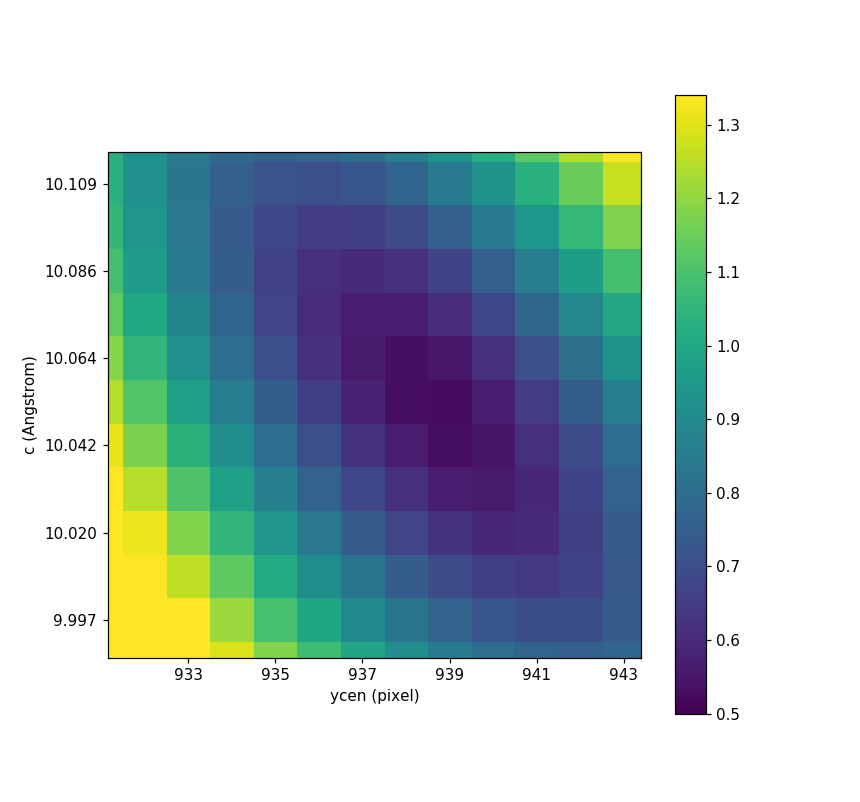

In [26]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl

fig2, ax2 = plt.subplots(figsize=(6,6))

pp = ax2.imshow(np.array(RESULTS)[:,2].reshape((nbptsc,nbptsycen)),origin='lower', vmin=.5, vmax=1.34)


fmt = lambda x, pos: '{:.3f}'.format(x*.2/18+9.953, pos)
ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
ax2.set_ylabel('c (Angstrom)')
fmtx = lambda x, pos: '{:.0f}'.format(x*18/18+925, pos)
ax2.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmtx))
ax2.set_xlabel('ycen (pixel)')

plt.colorbar(pp)

In [28]:
import pickle

print('folder',folder)
if 0:
    with open(os.path.join(folder,'landscape_optim_calib.pickle'),'wb') as f:
        pickle.dump(np.array(RESULTS), f)
        
if 1:
    with open(os.path.join(folder,'landscape_optim_calib.pickle'),'rb') as f:
        RESULTS = pickle.load(f)


folder /home/micha/LaueProjects/SiC_rieutord/


<IPython.core.display.Javascript object>


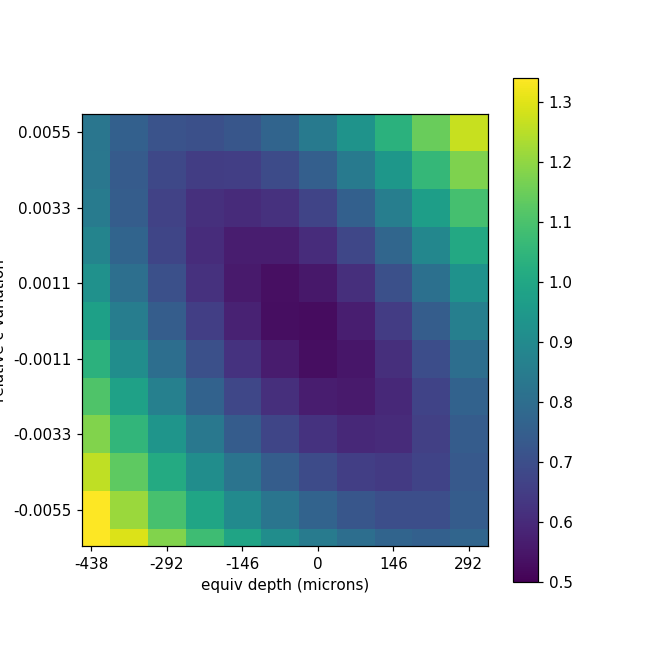

In [33]:
fig3, ax3 = plt.subplots(figsize=(6,6))

pp2 = ax3.imshow(np.array(RESULTS)[:,2].reshape((nbptsc,nbptsycen)),origin='lower',vmin=.5, vmax=1.34)


fmt = lambda x, pos: '{:.4f}'.format((x-9)*0.2/18/10.053, pos)
ax3.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
ax3.set_ylabel('relative c variation')
fmtx = lambda x, pos: '{:.0f}'.format((x-14)*73., pos)
ax3.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmtx))
ax3.set_xlabel('equiv depth (microns)')

plt.colorbar(pp2)

In [ ]:
# from above study: if mean origin of emission  is uncertain  + - 150 µm then c is + - 10-3  (0.1 %)

In [32]:
# variation of b  (should be constant and equal to a)
RESULTS[0]

array([ 9.952999999999999e+00, -1.300000000000000e+01,
        2.800940305212156e+00,  8.060283807046503e+01,
        9.753538839810216e+02,  3.061510855956402e-01,
        8.873815540765227e-01,  8.601879118074553e-02,
        1.006794882811117e-01, -6.449487937485386e-02])

# alumina study

In [2]:
def a(T, a0=4.81):
    return a0*(1-.176+5.431*0.0001*T+2.15*0.0000001*T**2-2.81*0.00000000001*T**3)

def c(T, c0=13.12):
    return c0*(1-.192+5.927*0.0001*T+2.142*0.0000001*T**2-2.207*0.00000000001*T**3)

Temp=np.linspace(298,1500+298,51)
print(Temp)

covera = c(Temp)/a(Temp)
covera

[ 298.  328.  358.  388.  418.  448.  478.  508.  538.  568.  598.  628.
  658.  688.  718.  748.  778.  808.  838.  868.  898.  928.  958.  988.
 1018. 1048. 1078. 1108. 1138. 1168. 1198. 1228. 1258. 1288. 1318. 1348.
 1378. 1408. 1438. 1468. 1498. 1528. 1558. 1588. 1618. 1648. 1678. 1708.
 1738. 1768. 1798.]


array([2.724579538563721, 2.728703990395995, 2.732692323832074,
       2.736551117016849, 2.740286753341744, 2.74390541545282 ,
       2.747413081305408, 2.750815521998513, 2.754118301146492,
       2.75732677556867 , 2.760446097099466, 2.763481215342296,
       2.766436881209632, 2.769317651109444, 2.772127891654489,
       2.774871784785875, 2.777553333215897, 2.780176366107349,
       2.782744544917654, 2.78526136934599 , 2.787730183330498,
       2.790154181050555, 2.792536412896033, 2.794879791371716,
       2.797187096910469, 2.799460983573494, 2.801703984620265,
       2.803918517934278, 2.806106891294014, 2.808271307481133,
       2.810413869220353, 2.812536583947414, 2.814641368403275,
       2.816730053054115, 2.818804386337925, 2.820866038739504,
       2.822916606696488, 2.824957616339745, 2.826990527071971,
       2.82901673498883 , 2.831037576147216, 2.833054329685545,
       2.835068220801111, 2.837080423589654, 2.839092063752376,
       2.841104221175601, 2.843117932388

In [3]:
#diff   every 30 K
covera[1:]-covera[:-1]

array([0.004124451832274, 0.003988333436079, 0.003858793184775,
       0.003735636324895, 0.003618662111076, 0.003507665852588,
       0.003402440693105, 0.00330277914798 , 0.003208474422177,
       0.003119321530797, 0.00303511824283 , 0.002955665867336,
       0.002880769899812, 0.002810240545045, 0.002743893131387,
       0.002681548430021, 0.002623032891452, 0.002568178810305,
       0.002516824428335, 0.002468813984509, 0.002423997720057,
       0.002382231845477, 0.002343378475683, 0.002307305538753,
       0.002273886663026, 0.002243001046771, 0.002214533314013,
       0.002188373359735, 0.002164416187119, 0.00214256173922 ,
       0.002122714727061, 0.002104784455862, 0.00208868465084 ,
       0.00207433328381 , 0.002061652401579, 0.002050567956984,
       0.002041009643257, 0.002032910732226, 0.00202620791686 ,
       0.002020841158386, 0.002016753538329, 0.002013891115566,
       0.002012202788543, 0.002011640162722, 0.002012157423224,
       0.002013711212706, 0.002016260514

In [4]:
# ~ relative diff  every 30 K
(covera[1:]-covera[:-1])/covera[:-1]

array([0.001513793880449, 0.001461621872551, 0.001412084760191,
       0.001365089181658, 0.001320541401977, 0.001278347946264,
       0.001238416136349, 0.001200654541014, 0.00116497334949 ,
       0.001131284677041, 0.001099502810803, 0.001069544403243,
       0.001041328619994, 0.001014777248077, 0.000989814769963,
       0.000966368408344, 0.000944368145909, 0.00092374672399 ,
       0.00090443962344 , 0.000886385030748, 0.000869523791991,
       0.000853799356916, 0.000839157715137, 0.000825547326177,
       0.000812919044828, 0.000801226043132, 0.000790423730048,
       0.000780469669763, 0.000771323499413, 0.000762946846878,
       0.000755303249215, 0.000748358072167, 0.000742078431123,
       0.000736433113837, 0.000731392505124, 0.000726928513734,
       0.000723014501532, 0.000719625215071, 0.000716736719652,
       0.000714326335858, 0.000712372578634, 0.000710855098846,
       0.000709754627342, 0.000709052921446, 0.000708732713854,
       0.000708777663873, 0.000709172310

<IPython.core.display.Javascript object>


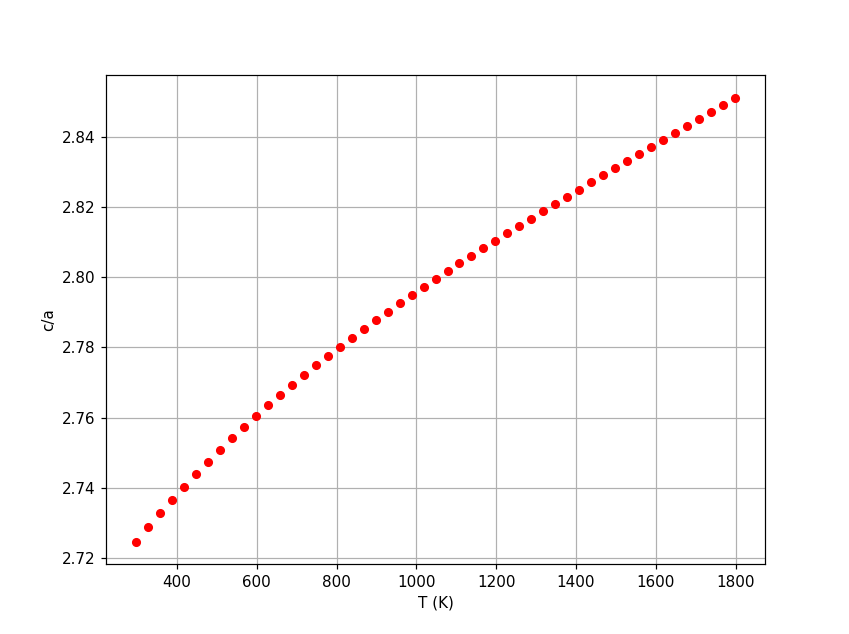

In [6]:
fig3, ax3 = plt.subplots(figsize=(6,6))

ax3.plot(Temp, covera, 'r.',markersize=10)
ax3.set_xlabel('T (K)')
ax3.set_ylabel('c/a')
ax3.grid()

In [ ]:
# frm the picture:   10 K is 0.1 % full uncertainty of c/a ratio  at 800K  and half that at 1600 K

# from above study: if  mean origin of emission is uncertain  + - 150 µm then c is + - 10-3  (0.1 %)
# but in our case, x ray beam come through the piece of alumina whatever T the same manner,
# so the origin of emission is translated 